In [73]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import os
from skimage import io

# 1. Setup Display Function
def show(image, title, cmap=None):
    plt.figure(figsize=(6, 6))
    if len(image.shape) == 3:
        # Convert BGR to RGB for matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        # Grayscale/Mask
        plt.imshow(image, cmap=cmap if cmap else 'gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

print("Libraries loaded. Ready for Phase 1.")

Libraries loaded. Ready for Phase 1.


Fetching image from: https://i.postimg.cc/MKfdq5cj/malakatad-20251127-024010.jpg


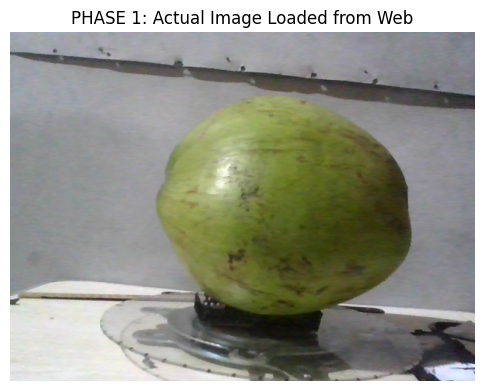

Success! Image is in memory. Ready for Phase 2.


In [74]:
# --- USER CONFIGURATION ---
# PASTE YOUR DIRECT LINKS HERE
# If you don't have your own link yet, use these examples of real coconuts:
image_urls = [
    "https://i.postimg.cc/MKfdq5cj/malakatad-20251127-024010.jpg",  # Image 0
    "https://i.postimg.cc/nh8Tzm7W/malauhog-20251127-024415.jpg"   # Image 1
]

image_index = 0 # Change to 1 for the second image

# --- LOAD DIRECTLY FROM WEB ---
url = image_urls[image_index]

try:
    print(f"Fetching image from: {url}")
    # scikit-image's 'io.imread' handles web URLs automatically
    image_rgb = io.imread(url)
    
    # Convert from RGB (Web standard) to BGR (OpenCV standard)
    original_img = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    
    show(original_img, f"PHASE 1: Actual Image Loaded from Web")
    print("Success! Image is in memory. Ready for Phase 2.")

except Exception as e:
    print(f"Error loading image: {e}")
    print("Make sure the link is a 'Direct Link' ending in .jpg or .png")

--- STARTING PHASE 2: PREPROCESSING ---


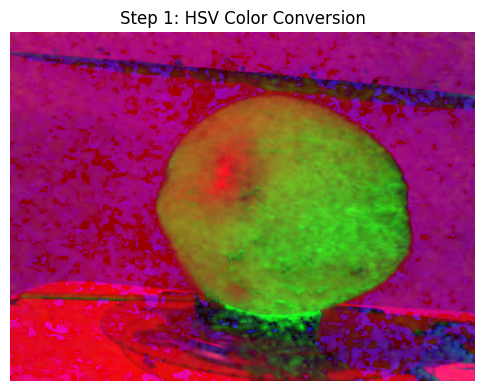

In [75]:
print("--- STARTING PHASE 2: PREPROCESSING ---")

# 1. HSV Conversion
hsv_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)
show(hsv_img, "Step 1: HSV Color Conversion")


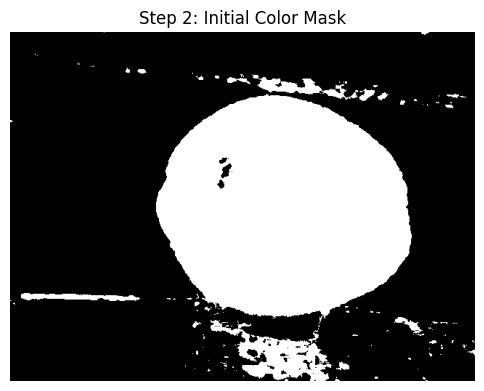

In [76]:

# 2. Masking (Thresholding)
lower = np.array([5, 30, 30])
upper = np.array([90, 255, 255])
mask = cv2.inRange(hsv_img, lower, upper)
show(mask, "Step 2: Initial Color Mask")

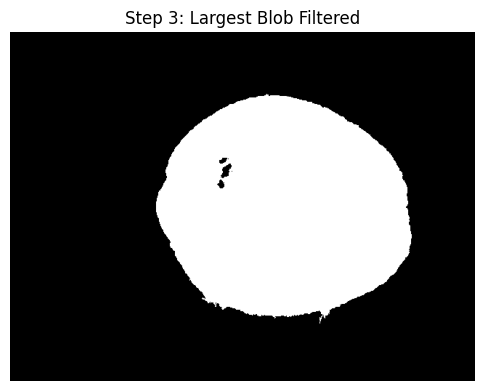

In [77]:

# 3. Blob Filtering (Largest Component)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
if num_labels > 1:
    # Get largest label (ignoring background 0)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    mask = np.uint8(labels == largest_label) * 255
    show(mask, "Step 3: Largest Blob Filtered")
else:
    mask = np.zeros_like(mask)
    print("Warning: No blob found.")


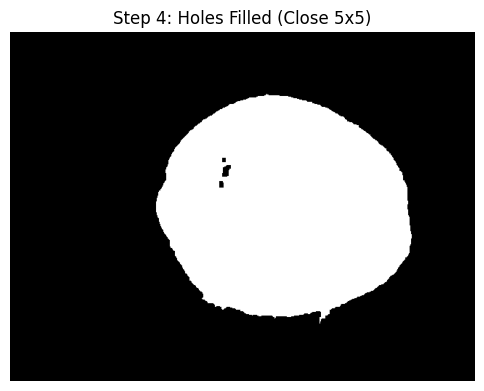

In [78]:
# 4. Hole Filling (Morph Close 5x5)
mask_filled = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
show(mask_filled, "Step 4: Holes Filled (Close 5x5)")

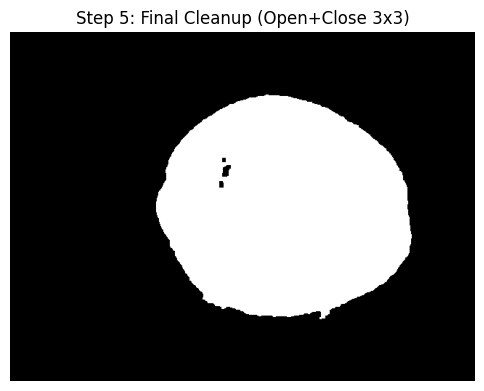

In [79]:
# 5. Morphological Cleanup (Open 3x3 then Close 3x3)
kernel = np.ones((3, 3), np.uint8)
mask_open = cv2.morphologyEx(mask_filled, cv2.MORPH_OPEN, kernel)
mask_final = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel)
show(mask_final, "Step 5: Final Cleanup (Open+Close 3x3)")

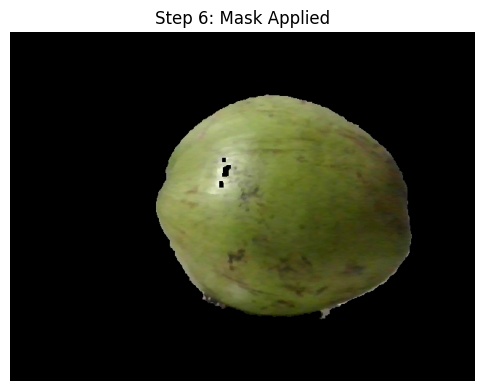

In [80]:
# 6. Apply Mask to Image
masked_img = cv2.bitwise_and(original_img, original_img, mask=mask_final)
show(masked_img, "Step 6: Mask Applied")

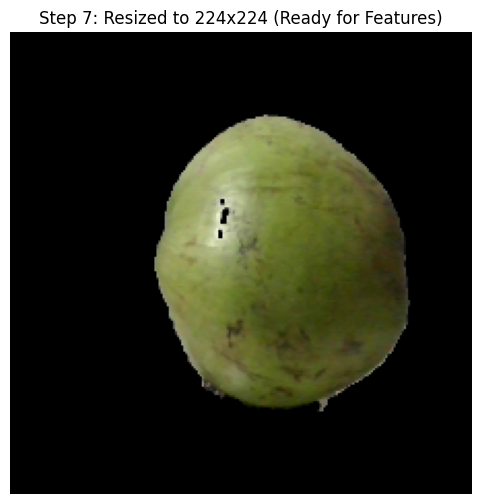

Phase 2 Complete. Preprocessed data ready for Tiling.


In [81]:

# 7. Final Resize (224, 224)
processed_img = cv2.resize(masked_img, (224, 224))
show(processed_img, "Step 7: Resized to 224x224 (Ready for Features)")
print("Phase 2 Complete. Preprocessed data ready for Tiling.")

--- STARTING PHASE 3: TILING SETUP ---


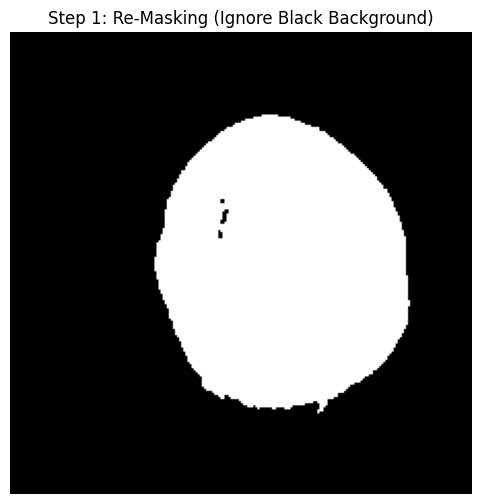

In [82]:
print("--- STARTING PHASE 3: TILING SETUP ---")

# 1. Convert Processed Image to HSV
hsv_feat = cv2.cvtColor(processed_img, cv2.COLOR_BGR2HSV)

# 2. Binary Mask (Exclude Black Background - Your Logic)
lower_b = np.array([1, 1, 1]) 
upper_b = np.array([255, 255, 255])
mask_feat = cv2.inRange(processed_img, lower_b, upper_b)
show(mask_feat, "Step 1: Re-Masking (Ignore Black Background)")

DEBUG: Found Bounding Box -> x=70, y=40, w=124, h=145


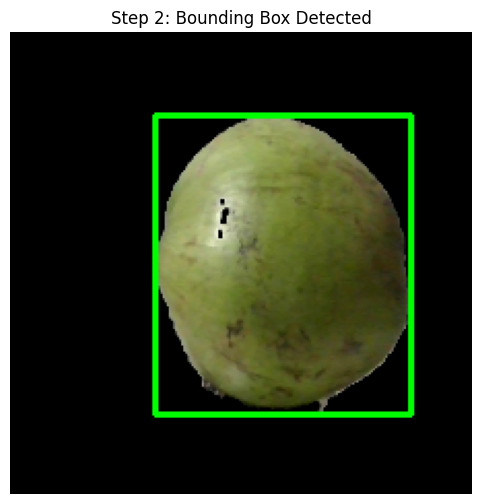

In [83]:
# 3. Find Bounding Box
contours, _ = cv2.findContours(mask_feat, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # Find largest contour
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    
    # DEBUG PRINT: Check what bbox we actually found
    print(f"DEBUG: Found Bounding Box -> x={x}, y={y}, w={w}, h={h}")

    # Visualize Bbox
    bbox_vis = processed_img.copy()
    cv2.rectangle(bbox_vis, (x, y), (x+w, y+h), (0, 255, 0), 2)
    show(bbox_vis, "Step 2: Bounding Box Detected")


DEBUG: roi_hsv shape is (145, 124, 3)


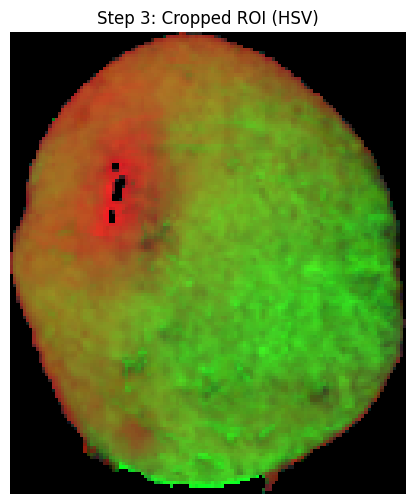

In [84]:

# 3. Crop HSV image and Mask to the bounding box
roi_hsv = hsv_feat[y:y+h, x:x+w]
roi_mask = mask_feat[y:y+h, x:x+w]
    
# DEBUG PRINT: Check the shape of the crop
print(f"DEBUG: roi_hsv shape is {roi_hsv.shape}")

if roi_hsv.size == 0 or w == 0 or h == 0:
    print("CRITICAL ERROR: The cropped image is EMPTY. Cannot draw grid.")
    print("Reason: Bounding box width or height is 0.")
else:
    show(roi_hsv, "Step 3: Cropped ROI (HSV)")

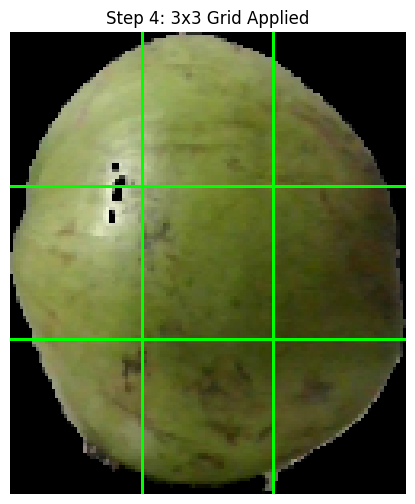

Phase 3 Success! ROI is ready.


In [85]:
# 4. Visualize 3x3 Grid (Safe to run now)
try:
    grid_vis = cv2.cvtColor(roi_hsv, cv2.COLOR_HSV2BGR)
    h_roi, w_roi, _ = roi_hsv.shape
    h_step = h_roi // 3
    w_step = w_roi // 3

    # Draw lines
    for i in range(1, 3):
        cv2.line(grid_vis, (0, i * h_step), (w_roi, i * h_step), (0, 255, 0), 1)
        cv2.line(grid_vis, (i * w_step, 0), (i * w_step, h_roi), (0, 255, 0), 1)

    show(grid_vis, "Step 4: 3x3 Grid Applied")
    print("Phase 3 Success! ROI is ready.")
        
except cv2.error as e:
     print(f"OpenCV Error during grid drawing: {e}")

In [86]:
def compute_moments(pixel_array):
    # Matches your helper function exactly
    if len(pixel_array) == 0:
        return 0.0, 0.0, 0.0, 0.0
    if len(np.unique(pixel_array)) == 1:
        return float(pixel_array[0]), 0.0, 0.0, 0.0
    
    m1 = np.mean(pixel_array)
    m2 = np.std(pixel_array)
    m3 = skew(pixel_array, bias=False)
    m4 = kurtosis(pixel_array, bias=False)
    
    # NaN checks
    m3 = 0.0 if np.isnan(m3) else m3
    m4 = 0.0 if np.isnan(m4) else m4
    return m1, m2, m3, m4

feature_data = []

if roi_hsv is not None:
    # Recalculate steps for the crop
    h_roi, w_roi, _ = roi_hsv.shape
    step_h = h_roi // 3
    step_w = w_roi // 3

    channel_names = ["Hue", "Saturation", "Value"]

    # Loop 3x3
    for row in range(3):
        for col in range(3):
            # Calc coords
            y_start = row * step_h
            y_end = (row + 1) * step_h if row < 2 else h_roi
            x_start = col * step_w
            x_end = (col + 1) * step_w if col < 2 else w_roi

            # Extract Tile
            tile_hsv = roi_hsv[y_start:y_end, x_start:x_end]
            tile_mask = roi_mask[y_start:y_end, x_start:x_end]

            # Process H, S, V
            for i in range(3):
                channel_pixels = tile_hsv[:, :, i]
                # FILTER: Only take pixels where mask > 0 (Your logic)
                valid_pixels = channel_pixels[tile_mask > 0]
                
                # Compute
                m1, m2, m3, m4 = compute_moments(valid_pixels)
                
                # Store
                base_name = f"R{row}C{col}_{channel_names[i]}"
                feature_data.append({"Feature": f"{base_name}_Mean", "Value": m1})
                feature_data.append({"Feature": f"{base_name}_Std", "Value": m2})
                feature_data.append({"Feature": f"{base_name}_Skew", "Value": m3})
                feature_data.append({"Feature": f"{base_name}_Kurt", "Value": m4})

    # Show Table
    df = pd.DataFrame(feature_data)
    pd.set_option('display.max_rows', None)
    display(df)
    print(f"Total Features: {len(df)}")

,Feature,Value
0,R0C0_Hue_Mean,34.582534
1,R0C0_Hue_Std,2.315226
2,R0C0_Hue_Skew,-0.969270
3,R0C0_Hue_Kurt,5.666208
4,R0C0_Saturation_Mean,76.993282
5,R0C0_Saturation_Std,20.138030
6,R0C0_Saturation_Skew,-0.419805
7,R0C0_Saturation_Kurt,-0.255379
8,R0C0_Value_Mean,171.883877
9,R0C0_Value_Std,23.504093


Total Features: 108
